В машинном обучении есть два типа параметров.

**Внутренние (параметры модели)**

Подбираются во время обучения и определяют, как использовать входные данные для получения необходимого результата.<br>
Например, это веса (коэффициенты уравнения) в линейной/логистической регрессии.

**Внешние (параметры алгоритма)**

Их принято называть **гиперпараметрами**. Внешние параметры могут быть произвольно установлены перед началом обучения и контролируют внутреннюю работу обучающего алгоритма.<br>
Например, это параметр регуляризации в линейной/логистической регрессии.

**Гиперпараметры** отвечают за сложность взаимосвязи между входными признаками и целевой переменной, поэтому сильно влияют на модель и качество прогнозирования.

Продемонстрируем это на примере задачи **регрессии** с помощью двух графиков работы алгоритма случайного леса, построенного на основе 5, 100 деревьев (n_estimators = [5, 100]):

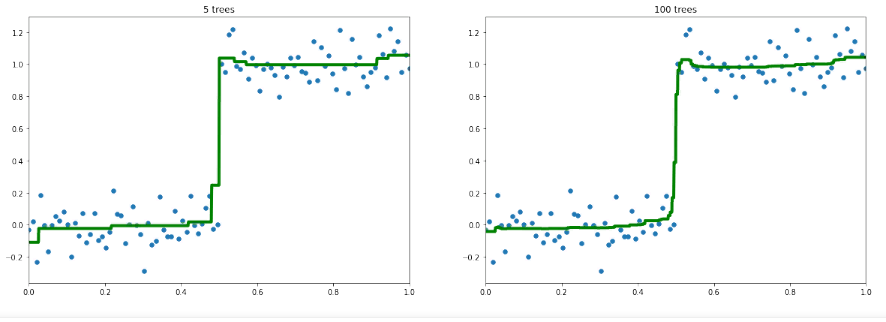

Видим, что при 100 деревьях модель находит более сложную закономерность в данных и точность соответственно будет выше, чем при 5.

Каждый алгоритм МО имеет набор гиперпараметров, которые определяют, как именно он строит модель на обучающей выборке. 

Например, в модуле ML-2 для повышения эффективности модели мы уже рассматривали подбор параметра регуляризации  для алгоритма линейной регрессии Ridge.

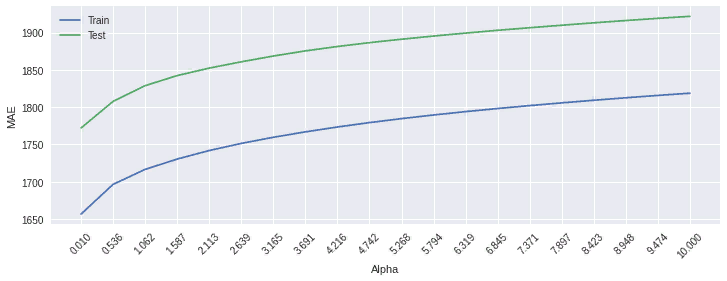

Наилучшее значение метрики соответствует alpha=0.01 (кстати, можно попробовать перебрать значения  alpha<=0.01).

В данном случае мы просто воспользовались циклом for и перебрали некоторые заданные значения alpha, хотя, по всей видимости, не самые оптимальные. Поэтому подобранные эмпирическим путём значения гиперпараметров с большей вероятностью дадут низкую прогностическую эффективность.

Также рассмотренный метод визуализации зависимости метрики от гиперпараметра позволяет выбрать только один внешний параметр, в данном случае — alpha. А что делать, если у нас не один, а несколько? 

Например, вспомним основные внешние параметры DecisionTreeClassifier:

- criterion 
- max_depth 
- max_features
- min_samples_leaf 

Тщательный подбор гиперпараметров гарантирует, что модель покажет максимально возможную точность на обучающих данных, но это **совершенно не означает хороший результат на тестовых или новых данных**.

Поиск оптимальных значений гиперпараметров модели является сложной задачей, обязательной почти для всех моделей и наборов данных

## 2. Базовая оптимизация

Наиболее часто используемый метод — это **поиск по сетке** (*grid search*), который по сути является попыткой перебрать все возможные комбинации заданных гиперпараметров. Мы указываем список значений для различных гиперпараметров, и, ориентируясь на нашу метрику, оцениваем эффективность модели для каждого их сочетания, чтобы получить оптимальную комбинацию значений.

Допустим, мы хотим подобрать гиперпараметры *min_samples_leaf* и *max_depth* для алгоритма *DecisionTreeClassifier*. Зададим списки их значений:

In [ ]:
min_samples_leaf = [3, 5, 8, 9]
max_depth = [4, 5, 6, 7, 8]

Поскольку нам нужно перебрать четыре различных значения для *min_samples_leaf* и пять — для *max_depth*, то получается всего 4*5=20 комбинаций. Модель будет обучена 20 раз; столько же раз будет рассчитана метрика.

Сетка выглядит следующим образом:

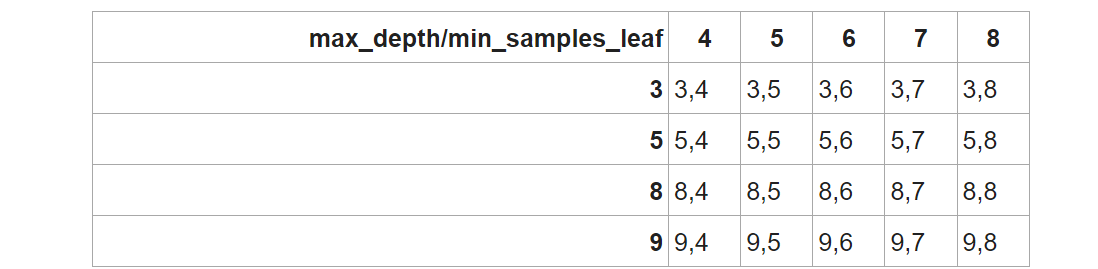

<center>$\color{green}{\text{ОПАСНОСТЬ ПЕРЕОБУЧЕНИЯ И УТЕЧКИ ДАННЫХ}}$</center>

Поскольку мы использовали тестовый набор для настройки гиперпараметров, мы больше не можем использовать его для оценки качества модели. Теперь в этих целях нам необходим независимый набор данных, то есть набор, который не использовался для построения модели и настройки её гиперпараметров.

Следовательно, надо разбить данные на **три части: обучающую** для построения модели, проверочную (**валидационную**) для выбора гиперпараметров модели, а также **тестовую** для оценки качества модели и выбранных гиперпараметров. 

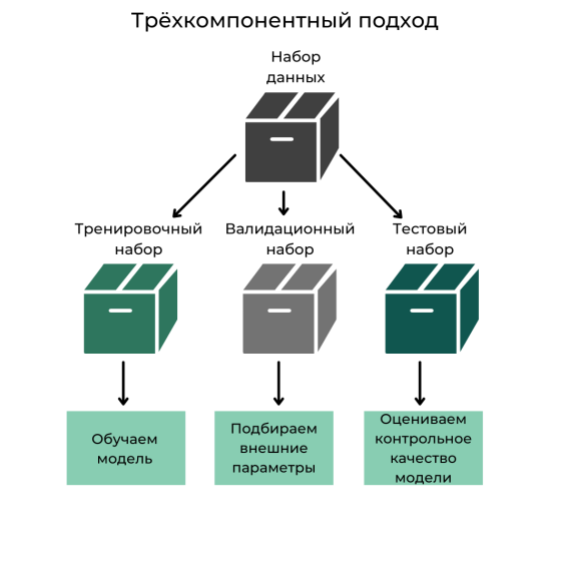

 <p style="background: #ffc7c7; border:1px black  solid; text-align: left; padding: 10px">
Наличие всех трёх наборов данных критически важно для использования МО. Любой подбор гиперпараметров, сделанный на тестовых данных, «сливает» модели информацию, содержащуюся в них, и может привести к неправильной оценке качества модели. Такая проблема относится к категории утечки данных, которую мы уже тоже затрагивали в модуле по валидации.

 <p style="background: #E1DEDE; border:1px black  solid; text-align: left; padding: 10px">
Рассмотренный метод разбиения данных на обучающий, проверочный и тестовый наборы является вполне рабочим и относительно широко используемым, но весьма чувствителен к равномерности разбиения данных. 

Для лучшей оценки обобщающей способности вместо одного разбиения данных на обучающий и проверочный наборы мы можем воспользоваться перекрёстной проверкой, то есть **кросс-валидацией** (*cross validation*). В таком случае качество модели оценивается для каждой комбинации гиперпараметров по всем разбиениям кросс-валидации. 

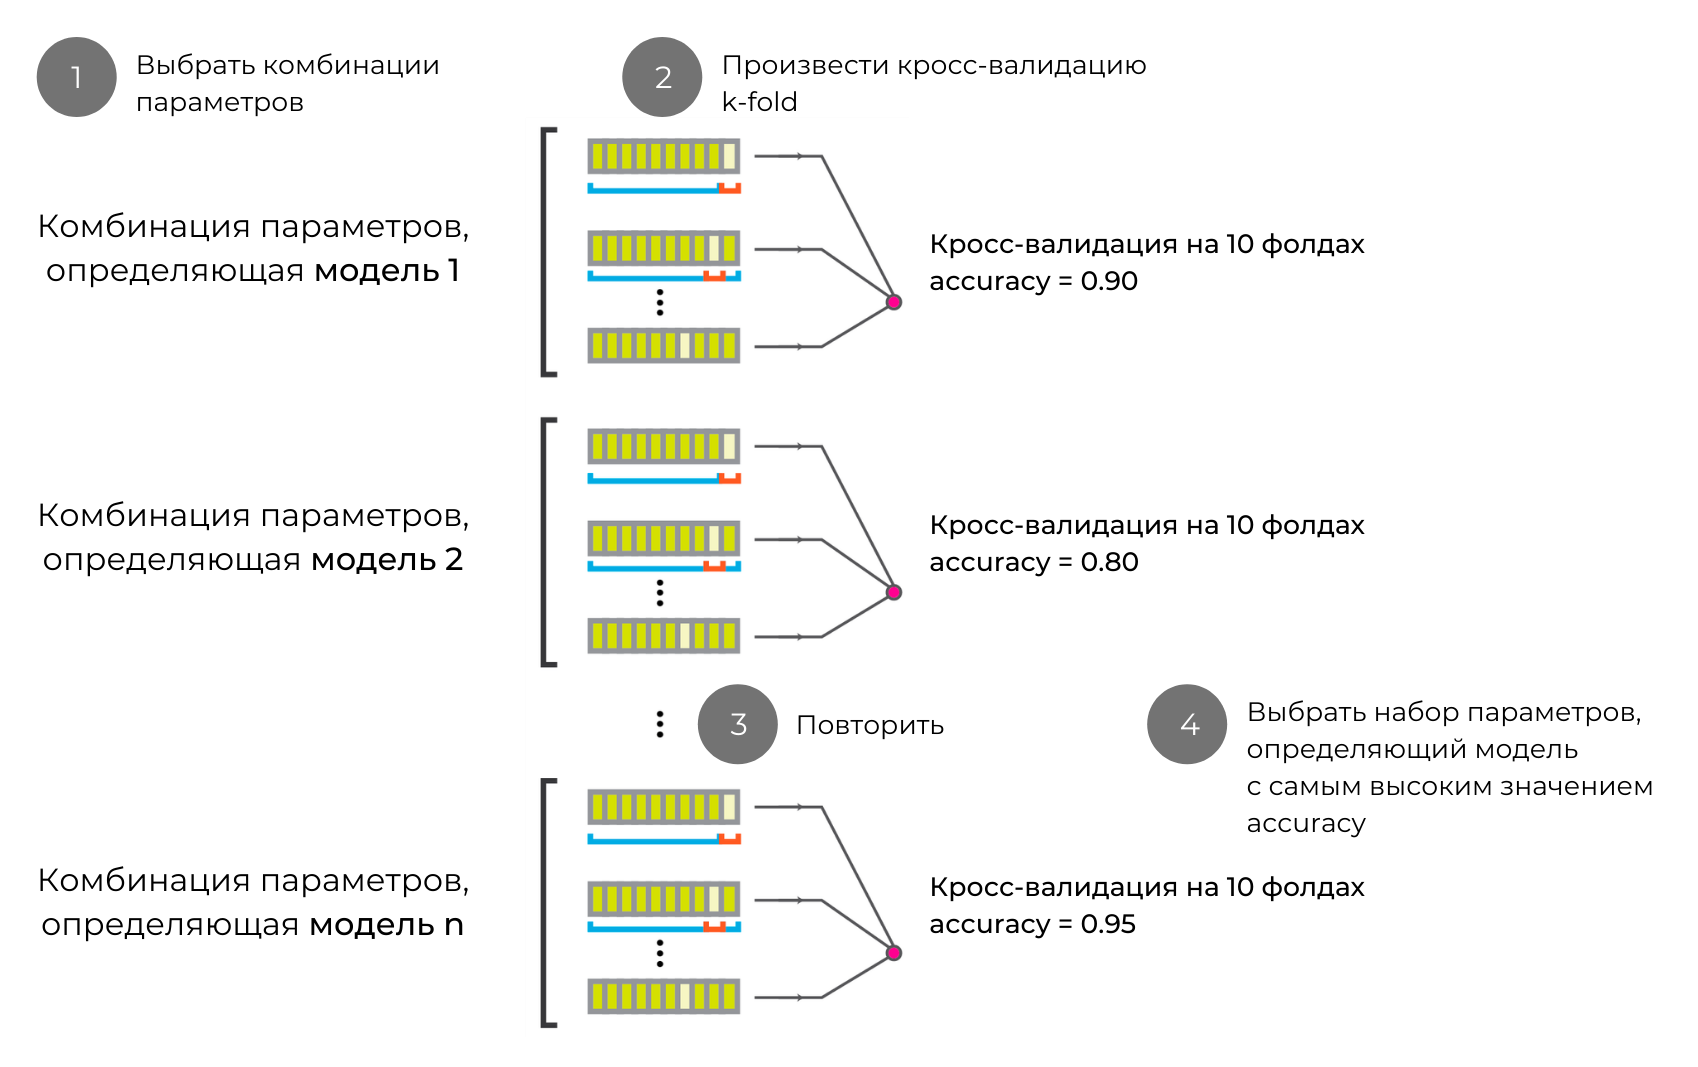

 <p style="border:3px black  solid; text-align: left; padding: 10px">
<b>Пояснение к рисунку</b>. Предположим, что у нас есть n комбинаций гиперпараметров. Берём первую комбинацию и обучаем на них первую модель с помощью кросс-валидации с 10 фолдами (cv=10), затем рассчитываем метрику как среднее по всем разбиениям. Так проделываем для каждой комбинации и выбираем ту, при которой наша метрика наилучшая. В итоге мы обучим n*cv моделей, но выберем один набор гиперпараметров, который и будет использоваться для обучения итоговой модели на всей обучающей выборке.

<center>$\color{green}{\text{GRIDSEARCHCV}}$</center>

Поскольку поиск по сетке с кросс-валидацией является весьма распространённым методом настройки гиперпараметров, библиотека *scikit-learn* предлагает класс **GridSearchCV**

**См. ML-7.Optimization_of_hyperparameters**

Основные параметры *GridSearchCV*:

- **estimator** — алгоритм, который будем оптимизировать;
- **param_grid** — словарь или список словарей. Словарь с именами гиперпараметров (в формате строки (str), например, 'max_depth') в качестве ключей и списками параметров (например, [5, 8, 10]) в качестве значений. Итого: {'max_depth': [5, 8, 10] }.
- **scoring** — по умолчанию используется score-функция заданного алгоритма:
 - для классификации — sklearn.metrics.accuracy_score;
 - для регрессии — sklearn.metrics.r2_score;

Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите [здесь](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.

Чтобы воспользоваться классом *GridSearchCV*, необходимо:

**1**. Импортировать библиотеку:

In [ ]:
from sklearn.model_selection import GridSearchCV

**2**. Указать искомые гиперпараметры в виде словаря  **param_grid**: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров. Мы рассмотрим сетку из:

- 'penalty' — тип регуляризации. Может принимать значения l1,  l2, 'elasticnet' или None (отсутствие регуляризации);
- 'solver' — алгоритм оптимизации, может принимать значения 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', по умолчанию — 'lbfgs'.

Важно помнить, что выбор алгоритма оптимизации зависит от выбранного типа штрафа:

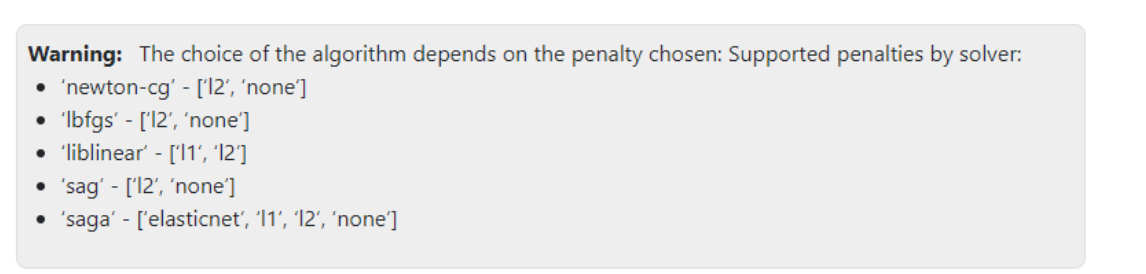

In [ ]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
                  'solver': ['lbfgs', 'saga'] #алгоритм оптимизации
                  }

**3**. Вызвать класс *GridSearchCV* и передать модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, и n_jobs = -1, чтобы использовать все доступные ядра для расчётов:

In [ ]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=1, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

**4**. Созданный нами объект **grid_search** аналогичен классификатору, поэтому мы можем вызвать стандартные методы *fit, predict и score* от его имени. Однако, когда мы вызываем **fit()**, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в **param_grid**:

In [ ]:
grid_search.fit(X_train_scaled, y_train) 
#Затраченное время: 1min 4s

 <p style="border:3px aquamarine  dotted; text-align: centre; padding: 10px">
GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всём обучающем наборе данных с использованием параметров, которые дают наилучшее значение метрики при кросс-валидации.

Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте **best_params_**:

In [ ]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
# Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}

Наилучшая метрика:

In [ ]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

Либо можем посмотреть любую другую метрику, воспользовавшись методом predict() и передав предсказанные значения в функцию для расчёта метрики (например, f1_score()): 

In [ ]:
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
 
# accuracy на тестовом наборе: 0.84
# f1_score на тестовом наборе: 0.64

Итоговая модель хранится в параметре **best_estimator_**, ей можно воспользоваться для получения прогнозов на новых данных: 

In [ ]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
#Наилучшая модель: LogisticRegression(max_iter=1000, penalty='none', random_state=1)

А наилучшее значение метрики на кросс-валидации (значение метрики, усреднённое по всем разбиениям для данной комбинации гиперпараметров) хранится в атрибуте **best_score_**. 

In [ ]:
print("Наилучшее значение точности при кросс-валидации: {:.2f}".format(grid_search.best_score_))
#Наилучшее значение точности при кросс-валидации: 0.84

 <p style="background: #E1DEDE; border:1px black  solid; text-align: left; padding: 10px">
<b>Примечание</b>. Не путайте <b>best_score_</b> со значением метрики модели, которое вычисляется на тестовом наборе с помощью метода <b>score</b>. Метод score (оценивающий качество результатов, полученных с помощью метода predict()) использует модель, построенную на всём обучающем наборе данных. В атрибуте best_score_ записывается <b>средняя метрика на кросс-валидации</b>.

Результаты кросс-валидации хранятся в параметре **cv_results_**. Отрисуем, как менялась метрика при различных гиперпараметрах:

In [ ]:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
               values='mean_test_score', index='param_C',
               columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

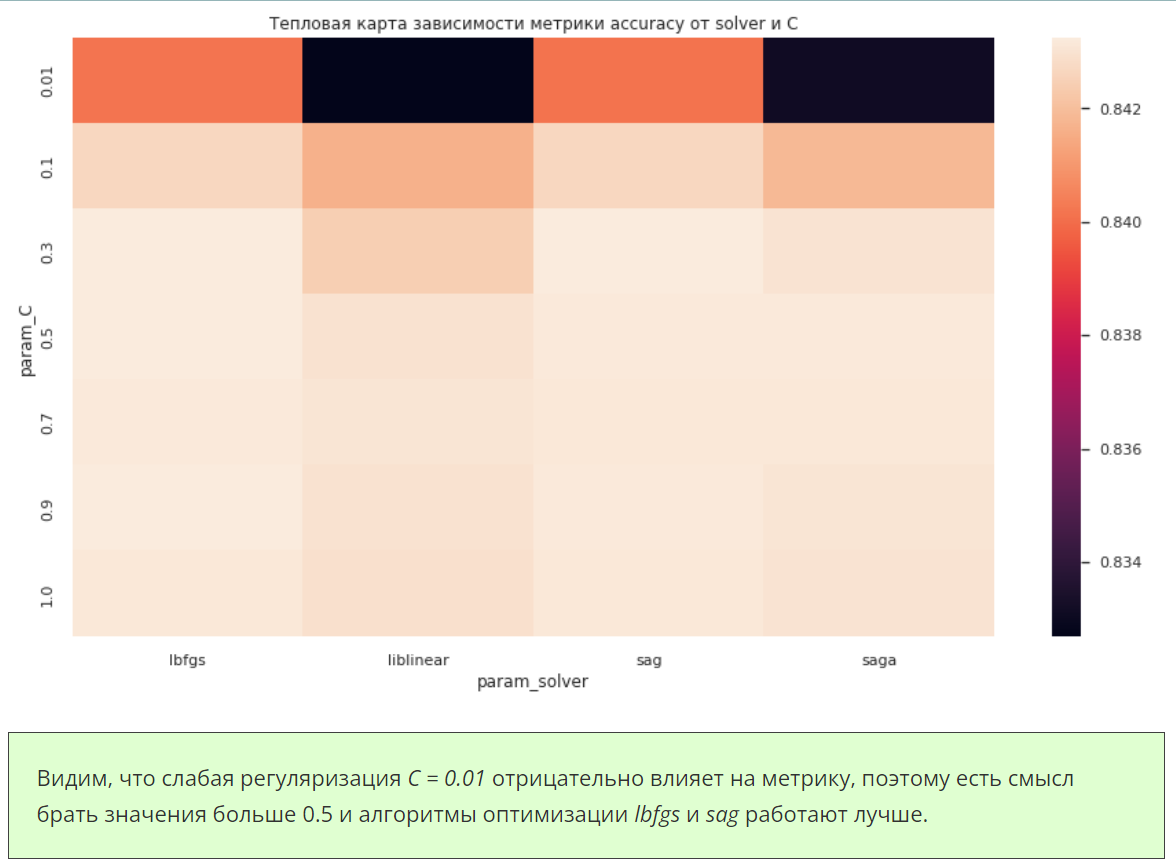

<center>$\color{green}{\text{RANDOMIZEDSEARCHCV}}$</center>

 <p style="background: #ffc7c7; border:1px black  solid; text-align: left; padding: 10px">
Несмотря на то, что поиск по сетке — мощный метод для нахождения оптимального набора гиперпараметров, оценка всех возможных комбинаций требует множество времени и вычислительных ресурсов, а также кросс-валидации для обучения моделей.

**RandomizedSearchCV. Рандомизированный** поиск работает почти так же, как решётчатый поиск, за исключением того, что перебираются не всевозможные комбинации параметров, а из них случайным образом выбираются n возможных вариантов комбинаций. Количество комбинаций параметров (n), которые используются в случайном поиске, мы задаём самостоятельно, что позволяет управлять временем, затрачиваемым на оптимизацию.

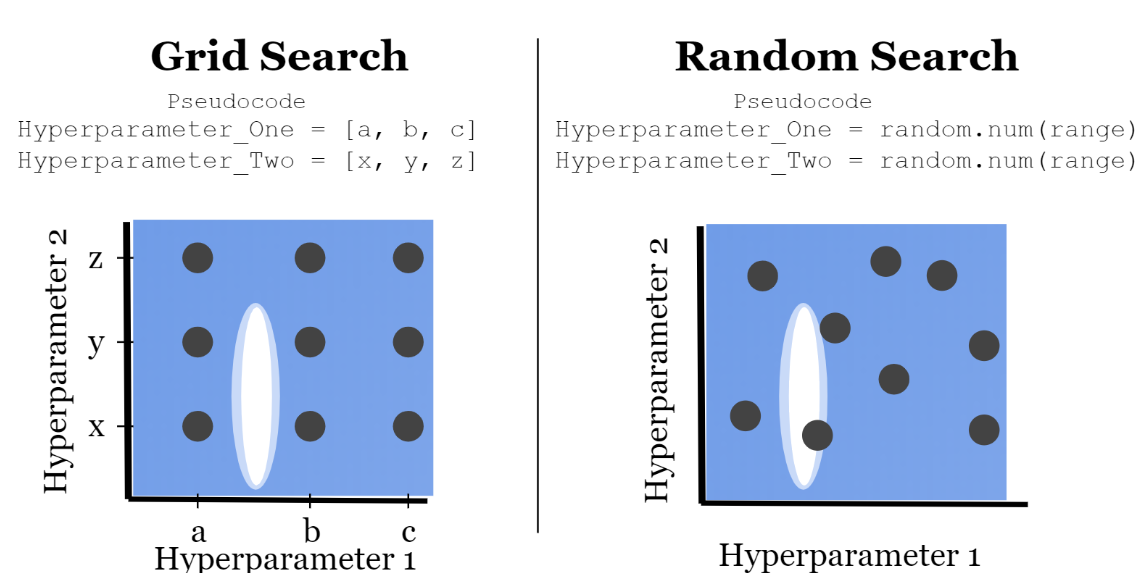

На этой картинке изображено принципиальное различие двух методов: 

- В *GridSearchCV* сетка задаётся вручную, перебираются различные значения гиперпараметров с каким-то шагом, в итоге получается что-то похожее на «красивую» сетку слева на картинке. Однако минимум функции (белое пятно) мы так и не обнаруживаем — а ведь он где-то рядом, возможно, просто между подобранными нами комбинациями.
- *RandomizedSearchCV* выбирает n (количество задаём сами) случайных точек/комбинаций из заданных нами последовательностей. Как следствие, мы можем перебирать не все возможные точки, а только часть из них, тем самым управляя скоростью работы перебора.

Основные параметры *RandomizedSearchCV* аналогичны *GridSearchCV*, за исключением наименований некоторых параметров и наличия параметра **n_iter**:

- **estimator** — алгоритм, который будем оптимизировать;
- **param_distributions** — cловарь с именами параметров (str) в качестве ключей и списками параметров в качестве значений, которые нужно попробовать.

Также можно передать список таких словарей:

In [ ]:
param_grid = [
              {'max_depth': [5, 8, 10],
               'min_samples_leaf': [7, 8, 9] } #первый словарь 
              {'n_estimators': [100, 200, 300], 
               'max_depth': [5, 8, 10] } #второй словарь 
             ]

В таком случае каждый словарь в списке перебирается отдельно и последовательно. Это позволяет выполнять поиск по любой последовательности настроек параметров.

Например, если количество итераций (параметр n_iter) равно 2, то сначала будет дважды выбрана случайная комбинация параметров модели из словаря {'max_depth': [5, 8, 10], 'min_samples_leaf': [7, 8, 9]}, а после этого, опять же дважды, случайная комбинация из словаря {'n_estimators': [100, 200, 300], 'max_depth': [5, 8, 10]}.

- **scoring** — по умолчанию используется score-функция заданного алгоритма:
 - для классификации — sklearn.metrics.accuracy_score;
 - для регрессии — sklearn.metrics.r2_score.

- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
- **n_iter** — количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

Начнём с импорта класса из библиотеки.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

**См. ML-7.Optimization_of_hyperparameters**

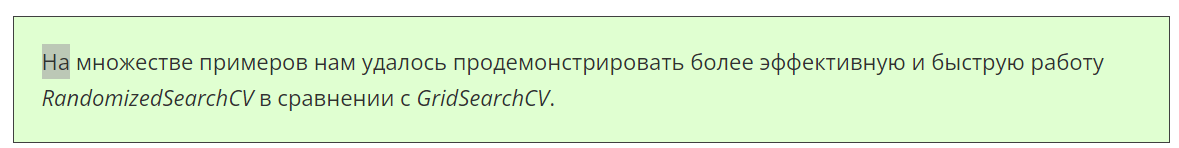

<center>$\color{green}{\text{РЕКОМЕНДАЦИИ ПО НАСТРОЙКЕ ГИПЕРПАРАМЕТРОВ АНСАМБЛЕЙ НАД РЕШАЮЩИМИ ДЕРЕВЬЯМИ}}$</center>

**АЛГОРИТМ СЛУЧАЙНОГО ЛЕСА (RANDOMFOREST)**

- **n_estimators** — число итераций (количество деревьев). Частично работает правило «чем больше, тем лучше», но иногда это не имеет особого смысла и сильно увеличивает затраты, поэтому стоит пробовать обучать сотни деревьев [100,200, 300, 400]. Если нет изменений, то оставить минимальное — 100.
- **max_depth** — максимальная глубина дерева. В случайном лесе строятся «сильные» деревья, каждое из которых даёт полноценный прогноз, поэтому глубина деревьем может быть достаточно большой. Стоит следить за переобучением.
- **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения;
- **max_samples** — доля выборки, которая будет использоваться для обучения каждого алгоритма — дерева.

**АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА (GRADIENTBOOSTING)**

- **n_estimators** — число итераций (количество деревьев) : хотя ошибка на обучении монотонно стремится к нулю, ошибка на контроле, как правило, начинает увеличиваться после определенной итерации. Оптимальное число итераций можно выбирать, например, по отложенной выборке или с помощью кросс-валидации.
- **learning_rate** — темп обучения (0;1]:<br>
На практике оказывается, что градиентный бустинг очень быстро строит композицию, ошибка которой на обучении выходит на асимптоту (достигает предела), после чего начинает настраиваться на шум и переобучаться. Параметр learning_rate контролирует, насколько сильно каждое дерево будет пытаться исправить ошибки предыдущих деревьев. Более высокая скорость обучения означает, что каждое дерево может внести более сильные корректировки. **Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции**.


- **max_depth** — максимальная глубина дерева. Используется для борьбы с переобучением. Рекомендуется устанавливать не более 5.
- **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения.
- **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма. Это ещё один способ улучшения качества градиентного бустинга. Таким образом вносится рандомизация в процесс обучения базовых алгоритмов, что снижает уровень шума в обучении, а также повышает эффективность вычислений. 

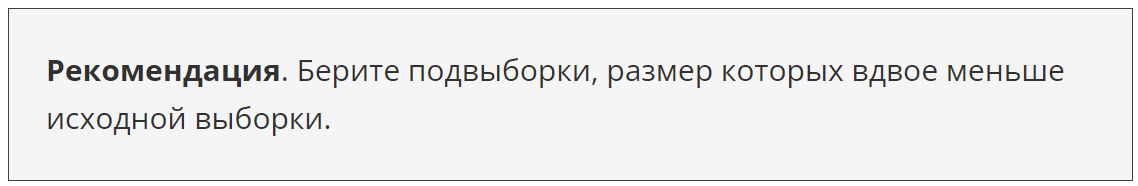

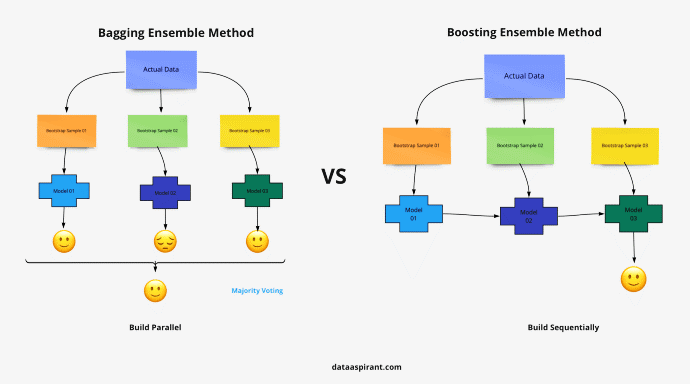

Главное отличие техник **Bagging и Boosting** состоит в параллельном и последовательном построении деревьев соответственно.

Основные параметры градиентного бустинга деревьев — это количество деревьев (**n_estimators**) и скорость обучения (**learning_rate**), контролирующие степень вклада каждого дерева в устранение ошибок предыдущих деревьев. Эти два параметра тесно взаимосвязаны, поскольку более низкое значение **learning_rate** означает, что для построения модели аналогичной сложности необходимо большее количество деревьев.

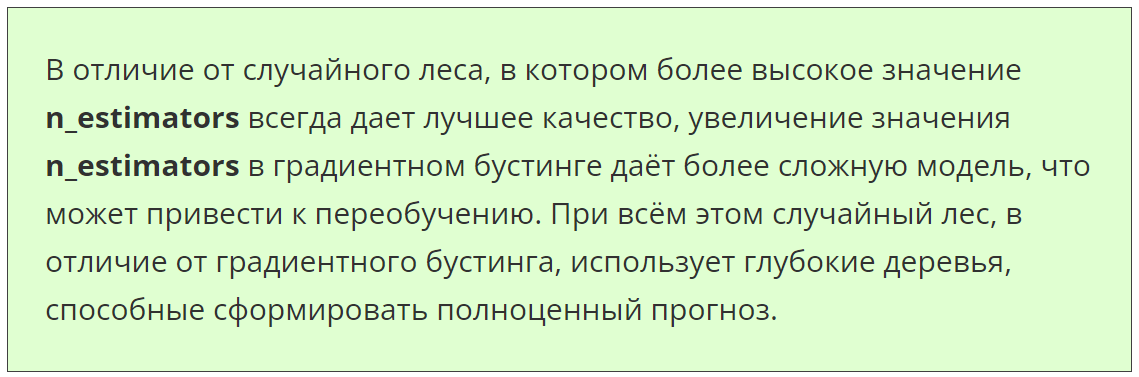

Общепринятая практика для бустинга — подгонять **n_estimators** в зависимости от бюджета времени и памяти, а затем подбирать различные значения **learning_rate**.

## 3. Продвинутая оптимизация

**Байесовская** оптимизация. Она отличается от случайного поиска или поиска по сетке тем, что учитывает предыдущие результаты, а не выбирает комбинации из вариантов, не имеющих информации о прошлых оценках. Во многих случаях это позволяет найти лучшие значения гиперпараметров модели за меньшее количество времени. Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей МО.

<center>$\color{green}{\text{TREE-STRUCTURED PARZEN ESTIMATORS (TPE)}}$</center>

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>1</strong></span> На каждой итерации алгоритм **TPE** учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше.

Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>2</strong></span>На следующем шаге происходит разделение собранных наборов на две группы:

- в первую группу входят наборы, дающие наилучшие результаты после оценки;
- во вторую — все остальные.

На изображении ниже: первая группа — <span style="color: #b8312f;">красные точки</span> находятся в области минимума целевой функции; вторая группа — <span style="color: #2969b0;">синие точки</span>, все остальные.

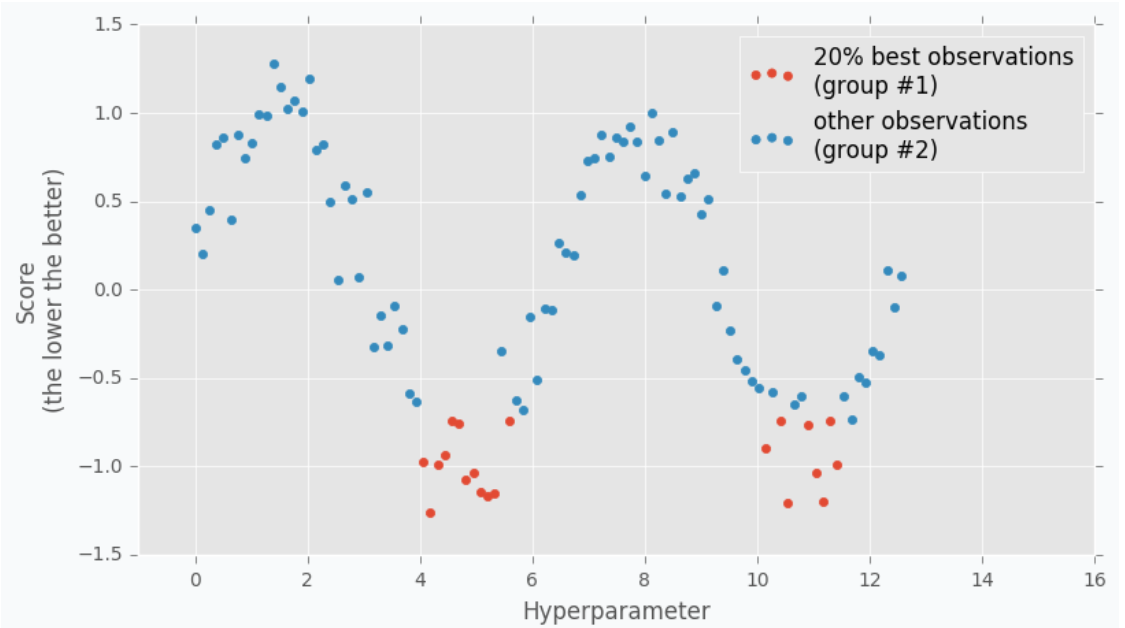

 <p style="background: #CCFFCC; border:1px black  solid; text-align: left; padding: 10px">
Основная цель алгоритма — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — красные точки на графике.

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>3</strong></span>Далее TPE моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:

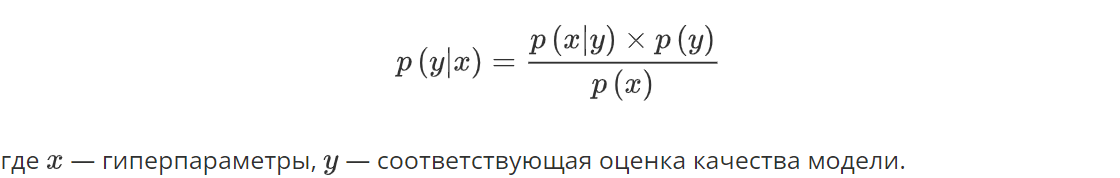

Подробнее про теорему Байеса можно прочитать по [ссылке](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0).

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>4</strong></span>Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 

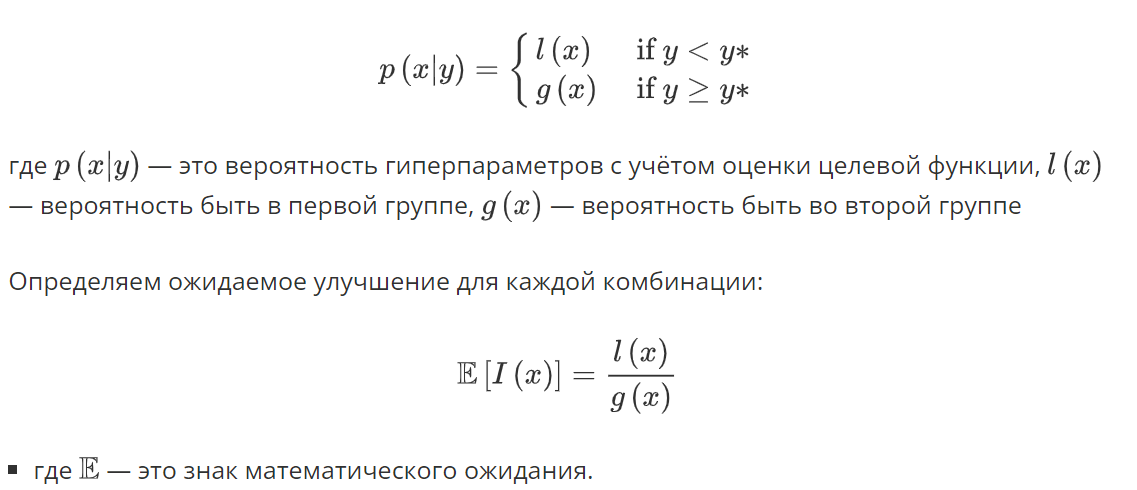

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>5</strong></span>Шаги 2-4  будет выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём наилучшую комбинацию гиперпараметров.

<center><b>HYPEROPT</b>

**Hyperopt** — это библиотека Python с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм **Tree-Structured Parzen Estimators (TPE)**.

Три шага для использования *Hyperopt*:

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>1</strong></span>Задание пространства поиска гиперпараметров.<br> 
Объявляем список гиперпараметров, тип распределения и его границы.

Основные (наиболее часто используемые) типы:

- ***hp.choice(label, options)*** — равновероятный выбор из массива. Массив (список/кортеж) вы задаёте сами, в списке могут быть как числа, так и строки (категории), но, как правило, данный метод используется для оптимизации категориального гиперпараметра (например, тип регуляризации в линейной регрессии или критерий информативности в деревьях);
- ***hp.randint(label, upper)*** — возвращает случайное целое число из диапазона [0, upper];
- ***hp.uniform(label, low, high)*** — создаёт равномерное непрерывное распределение и возвращает случайное число (не обязательно целое) из диапазона [low, high];
- ***hp.normal(label, mu, sigma)*** — создаёт нормальное непрерывное распределение с параметрами mu и sigma и возвращает случайное число из этого распределения;
- ***hp.lognormal(label, mu, sigma)*** — создаёт логнормальное непрерывное распределение с параметрами mu и sigma и возвращает случайное число из этого распределения.

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>2</strong></span>Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>3</strong></span>Задание алгоритма поиска:

- Random Search.
- Tree of Parzen Estimators (TPE).

Полезные ссылки: 

[Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms](https://lms-cdn.skillfactory.ru/assets/courseware/v1/32710b2c3069452833036ea0e4da10fe/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/bergstra_hyperopt.pdf)

[Hyperopt на GitHub](https://github.com/hyperopt/hyperopt/)

[Байесовский ниндзя (Хабр)](https://habr.com/ru/articles/494242/)

**См. ML-7.Optimization_of_hyperparameters - Hyperopt**

<center><b>OPTUNA

**Optuna** — это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию алгоритм удаляет комбинации, в которых модель даёт качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как *scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai* и другими.

Три шага для использования Optuna: 

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>1</strong></span>Задание пространства поиска гиперпараметров.

Основные функции:

*suggest_categorical(name, choices)* — для категориальных гиперпараметров;
*suggest_int(name,low,high,step=1,log=False)* — для целочисленных гиперпараметров;
*suggest_float(name,low,high,step=None,log=False)* — для непрерывных гиперпараметров;
*suggest_uniform(name,low,high)* — для целочисленных и непрерывных гиперпараметров.

С помощью необязательных аргументов step и log можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>2</strong></span>Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.

<span style="display: inline-block; text-align:center;  line-height: 30px;  font-size: 16px;color: #2e765e; width: 30px; height: 30px; border: 2px solid #2e765e; border-radius: 50%; margin: 0px 20px 20px;"><strong>3</strong></span>Создание объекта исследования <b>create study<b/>. 

По умолчанию используется алгоритм поиска TPE (есть и другие варианты) и вызов метода optimize(), в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное <b>n_trials</b> раз, подставляются различные комбинации гиперпараметров.

[Официальный сайт Optuma](https://optuna.org/)

**Код и интерактивные графики см. ML-7.Optimization_of_hyperparameters**

<center>$\color{green}{\text{ПЛЮСЫ И МИНУСЫ РАССМОТРЕННЫХ ФРЕЙМВОРКОВ И БИБЛИОТЕК}}$</center>

<table style="width: 100%; padding: 0.2em; border-collapse: collapse; margin: 0px auto; border: 1px solid #ababab;">
<tbody>
<tr>
<td style="width: 21.3358%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><strong>Название</strong></td>
<td style="width: 41.1898%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><strong>Плюсы&nbsp;</strong></td>
<td style="width: 37.3996%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><strong>Минусы</strong></td>
</tr>
<tr>
<td style="width: 21.3358%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><em>GridSearchCV</em></td>
<td style="width: 41.1898%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">
<p>✔️ Простой в использовании, идеален для небольшой сетки гиперпараметров</p>
<p>✔️ Встроенная кросс-валидация</p>
<p>✔️ Включает построение итоговой модели на всей обучающей выборке&nbsp;</p>
</td>
<td style="width: 37.3996%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">
<p>⛔️ Перебирает просто все комбинации заданной сетки гиперпараметров&nbsp;</p>
<p>⛔️ &nbsp;Требует много времени и вычислительных ресурсов</p>
</td>
</tr>
<tr>
<td style="width: 21.3358%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><em>RandomizedSearchCV</em></td>
<td style="width: 41.1898%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">✔️ Эффективнее и экономичнее <em>gridsearchcv</em>
<p>✔️ Можно задать количество рассматриваемых комбинаций</p>
</td>
<td style="width: 37.3996%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">⛔️ Просто выбирает рандомные комбинации гиперпараметров без учёта результатов прошлых итераций</td>
</tr>
<tr>
<td style="width: 21.3358%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><em>Hyperopt</em></td>
<td style="width: 41.1898%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">✔️ Быстрее и эффективнее, чем классические методы перебора (<em>GSCV</em> и <em>RSCV</em>)
<p>✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор</p>
<p>✔️ Можно отслеживать дополнительную информацию на каждом шаге с помощью класса <strong>Trials</strong></p>
<p>✔️ Возможность построения условного пространства поиска гиперпараметров и даже моделей</p>
</td>
<td style="width: 37.3996%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">⛔️ Старая документация, плохо с поддержкой и обновлением&nbsp;
<p>⛔️ Способен только минимизировать</p>
<p>⛔️ Непростой синтаксис описания пространства гиперпараметров (особенно с использованием условных реализаций)</p>
</td>
</tr>
<tr>
<td style="width: 21.3358%; text-align: center; vertical-align: middle; border: 1px solid #ababab; padding: 0.2em;"><em>Optuna</em></td>
<td style="width: 41.1898%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">✔️ Один из самых быстрых и эффективных
<p>✔️ Специально разработан для оптимизации гиперпараметров&nbsp;</p>
<p>✔️ Простой в использовании</p>
<p>✔️ Относительно новый фреймворк с хорошей документацией&nbsp;</p>
<p>✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор&nbsp;</p>
<p>✔️ Встроенная визуализация результатов</p>
<p>✔️ Возможность явно задавать максимизацию или минимизацию функции качества</p>
</td>
<td style="width: 37.3996%; text-align: left; vertical-align: top; border: 1px solid #ababab; padding: 0.2em;">⛔️ Удаление «плохих» точек пространства из рассмотрения
<p>⛔️ Не стоит полностью полагаться: важно с умом определять пространство поиска, что может значительно сократить время расчётов.</p>
<p></p>
</td>
</tr>
</tbody>
</table>